In [1]:


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from IPython.display import clear_output as cls
!pip install scipy nibabel
cls()

In [3]:
import os
import numpy as np
import tensorflow as tf

# Data
from glob import glob
from tqdm import tqdm
import nibabel as nib
from scipy import ndimage

# Data Visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Sequential
from keras.layers import Layer, Conv3D, BatchNormalization, MaxPool3D, GlobalAveragePooling3D as GAP3D, Dense, Dropout, InputLayer

# Optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
root_path = "/content/drive/MyDrive/n171_smwp1"

In [5]:
def load_nii(path):
    '''The function takes the path and loads the respective NII file.'''
    scan = nib.load(path)
    scan = scan.get_fdata()
    return scan

In [6]:
Images = glob(root_path+ "/*")

In [15]:
def process_scan(scan, desired_dims=(60,60,40)):
    '''The function takes in the scan and apply all the preprocessing steps.'''

    # Define range for normalization
    min, max = -1000, 400

    # define the values
    scan[scan < min] = min
    scan[scan > max] = max

    # normalize the images
    norm_sc = (scan - min)/(max - min)
    norm_sc = norm_sc.astype('float32')

    # Resizing The Scan
    curr_h, curr_w, curr_d = norm_sc.shape
    result_h, result_w, result_d = desired_dims

    # Use cubic spline interpolation to get results
    h_f = result_h/curr_h
    width_f = result_w/curr_w
    d_f = result_d/curr_d

    # resize the scan
    resized_scan = ndimage.zoom(norm_sc, zoom=(h_f, width_f, d_f), order=3)


    # convert the scan to single channel dimension
    rt_scan = tf.expand_dims(resized_scan, axis=-1)

    # Return the final Scan
    return rt_scan

In [16]:
scan_output = [process_scan(load_nii(img)) for img in Images]

In [19]:
scan_output[0]

<tf.Tensor: shape=(60, 60, 40, 1), dtype=float32, numpy=
array([[[[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]],

        [[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]],

        [[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]],

        ...,

        [[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]],

        [[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]],

        [[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]]],


   

In [20]:
scan_output[0]

<tf.Tensor: shape=(60, 60, 40, 1), dtype=float32, numpy=
array([[[[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]],

        [[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]],

        [[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]],

        ...,

        [[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]],

        [[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]],

        [[0.71428573],
         [0.71428573],
         [0.71428573],
         ...,
         [0.71428573],
         [0.71428573],
         [0.71428573]]],


   

In [21]:
len(scan_output)

171

In [22]:
def load_data(paths, label=0):

    # Create space for the data
    scans = np.empty(shape=(len(paths), 60, 60, 30, 1), dtype='float32') # This is from our prior knowledge
    labels = np.empty(shape=(len(paths),), dtype='int32')

    # Iterate through the paths and load the scan
    for i, path in tqdm(enumerate(paths), desc="Loading"):

        # load the Scan
        scan_1 = load_nii(path)

        # Process Scan
        pr_scan = process_scan(scan_1, desired_dims=(60,60,30))

        # Append Data
        scans[i] = pr_scan
        labels[i] = label

    # Return Data
    return scans, labels

In [23]:
all_pr_scans, all_labels = load_data(Images)

Loading: 171it [00:30,  5.58it/s]


In [24]:
import pandas as pd

# Load the CSV file as a Pandas DataFrame
df_1 = pd.read_csv('/content/drive/MyDrive/dataset.csv')

# Print the DataFrame
print(df_1)

             ID  PT500  PT4000
0    smwp1_0001   25.0    72.5
1    smwp1_0002    5.0    10.0
2    smwp1_0003    5.0    45.0
3    smwp1_0004    5.0    15.0
4    smwp1_0005    2.5    62.5
..          ...    ...     ...
166  smwp1_0167    0.0    27.5
167  smwp1_0168   37.5     2.5
168  smwp1_0169    7.5    10.0
169  smwp1_0170    0.0    -2.5
170  smwp1_0171   10.0    57.5

[171 rows x 3 columns]


In [25]:
# Access the 'PT500' column using iloc
pt500_column = df_1.iloc[:, 1]

# Print the 'PT500' column
print(pt500_column)

0      25.0
1       5.0
2       5.0
3       5.0
4       2.5
       ... 
166     0.0
167    37.5
168     7.5
169     0.0
170    10.0
Name: PT500, Length: 171, dtype: float64


In [26]:
pt4000_column = df_1.iloc[:, -1]

# Print the 'PT500' column
print(pt4000_column)

0      72.5
1      10.0
2      45.0
3      15.0
4      62.5
       ... 
166    27.5
167     2.5
168    10.0
169    -2.5
170    57.5
Name: PT4000, Length: 171, dtype: float64


In [27]:
df_pt4000 = pd.DataFrame({'PT4000': pt4000_column})

In [28]:
df_pt500 = pd.DataFrame({'PT500': pt500_column})

In [29]:
!pip install scikit-learn

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [66]:
C_value = 100
model = SVR(kernel='rbf',C = C_value ) #kernel is rbf

In [52]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_pr_scans, df_pt500, test_size=0.2, random_state=42)


In [53]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (136, 60, 60, 30, 1)
y_train shape: (136, 1)


In [54]:
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of samples: {X_train.shape[0]}")

Number of features: 60
Number of samples: 136


In [55]:
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))

In [56]:
X_train_transposed = X_train.transpose((0, 2, 3, 1, 4)).reshape((X_train.shape[0], -1))
X_test_transposed = X_test.transpose((0, 2, 3, 1, 4)).reshape((X_test.shape[0], -1))

model.fit(X_train_transposed, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100)

In [57]:
#accuracy of model
from sklearn.metrics import r2_score
y_pred = model.predict(X_test_transposed)
r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)


R2 score: 0.025829899759697073


In [99]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the mean absolute error
print("Mean absolute error:", mae)
print("Mean sqaured error:", mse)

Mean absolute error: 8.815030126460291
Mean sqaured error: 123.43132790493715


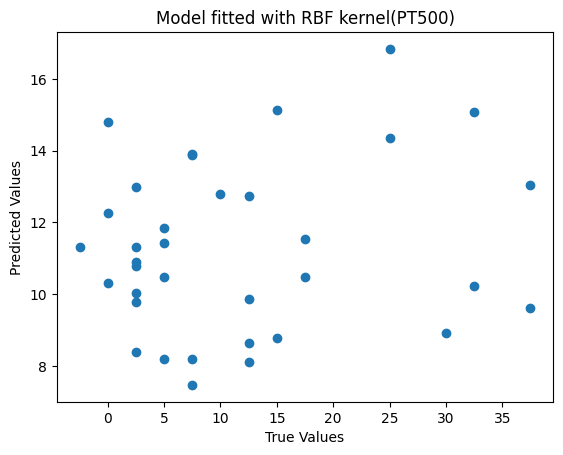

In [93]:
import matplotlib.pyplot as plt

# Create a scatter plot with predicted values on the x-axis and true values on the y-axis
plt.scatter(y_test, y_pred)

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model fitted with RBF kernel(PT500)')

# Show the plot
plt.show()

In [58]:
X1_train, X1_test, y1_train, y1_test = train_test_split(all_pr_scans, df_pt4000, test_size=0.2, random_state=42)

In [59]:
print(f"X_train shape: {X1_train.shape}")
print(f"y_train shape: {y1_train.shape}")

X_train shape: (136, 60, 60, 30, 1)
y_train shape: (136, 1)


In [60]:
print(f"Number of features: {X1_train.shape[1]}")
print(f"Number of samples: {X1_train.shape[0]}")

Number of features: 60
Number of samples: 136


In [61]:
X1_train_reshaped = X1_train.reshape((X1_train.shape[0], -1))
X1_test_reshaped = X1_test.reshape((X1_test.shape[0], -1))

X1_train_transposed = X1_train.transpose((0, 2, 3, 1, 4)).reshape((X1_train.shape[0], -1))
X1_test_transposed = X1_test.transpose((0, 2, 3, 1, 4)).reshape((X1_test.shape[0], -1))

model.fit(X1_train_transposed, y_train)

from sklearn.metrics import r2_score
y1_pred = model.predict(X1_test_transposed)
r2_1 = r2_score(y1_test, y1_pred)
print("R2 score:", r2_1)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 score: -0.7775926349617175


In [101]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Calculate the mean absolute error
mae_1 = mean_absolute_error(y1_test, y1_pred)
mse_1 = mean_squared_error(y1_test, y1_pred)

# Print the mean absolute error
print("Mean absolute error:", mae_1)
print("Mean squared error:", mse_1)

Mean absolute error: 20.47183576365283
Mean squared error: 742.1993411975873


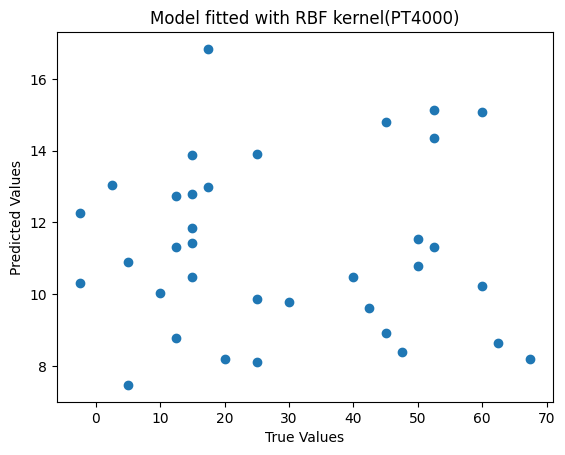

In [92]:
import matplotlib.pyplot as plt

# Create a scatter plot with predicted values on the x-axis and true values on the y-axis
plt.scatter(y1_test, y1_pred)

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model fitted with RBF kernel(PT4000)')

# Show the plot
plt.show()

In [75]:
#Use another model of SVR where kernel is linear : PT500 values
C_value = 100
model_1 = SVR(kernel='linear', C = C_value)

In [76]:
X_train_transposed = X_train.transpose((0, 2, 3, 1, 4)).reshape((X_train.shape[0], -1))
X_test_transposed = X_test.transpose((0, 2, 3, 1, 4)).reshape((X_test.shape[0], -1))

model_1.fit(X_train_transposed, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, kernel='linear')

In [77]:
#accuracy of model
from sklearn.metrics import r2_score
y_lr_pred = model_1.predict(X_test_transposed)
r2_lr = r2_score(y_test, y_lr_pred)
print("R2 score:", r2_lr)


R2 score: -0.012021866694413852


In [103]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Calculate the mean absolute error
mae_500 = mean_absolute_error(y_test, y_lr_pred)
mse_500 = mean_squared_error(y_test, y_lr_pred)
# Print the mean absolute error
print("Mean absolute error:", mae_500)
print("Mean sqaured error:", mse_500)

Mean absolute error: 8.920875529971505
Mean sqaured error: 128.22730121167893


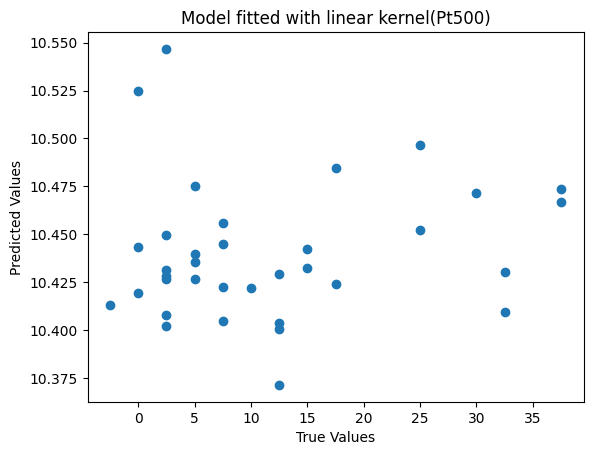

In [94]:
import matplotlib.pyplot as plt

# Create a scatter plot with predicted values on the x-axis and true values on the y-axis
plt.scatter(y_test, y_lr_pred)

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model fitted with linear kernel(Pt500)')

# Show the plot
plt.show()

In [79]:
#For pt_4000 values

In [104]:
X1_train_reshaped = X1_train.reshape((X1_train.shape[0], -1))
X1_test_reshaped = X1_test.reshape((X1_test.shape[0], -1))

X1_train_transposed = X1_train.transpose((0, 2, 3, 1, 4)).reshape((X1_train.shape[0], -1))
X1_test_transposed = X1_test.transpose((0, 2, 3, 1, 4)).reshape((X1_test.shape[0], -1))

model_1.fit(X1_train_transposed, y_train)

from sklearn.metrics import r2_score
y1_lr_pred = model_1.predict(X1_test_transposed)
r_lr_pt4000 = r2_score(y1_test, y1_lr_pred)
print("R2 score:", r_lr_pt4000)

# Calculate the mean absolute error
mae_4000 = mean_absolute_error(y1_test, y1_lr_pred)
mse_4000 = mean_squared_error(y1_test, y1_lr_pred)

# Print the mean absolute error
print("Mean absolute error:", mae_4000)
print("Mean squared error:", mse_4000)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 score: -0.8314913071505559
Mean absolute error: 21.215157685987652
Mean squared error: 764.7036867957801


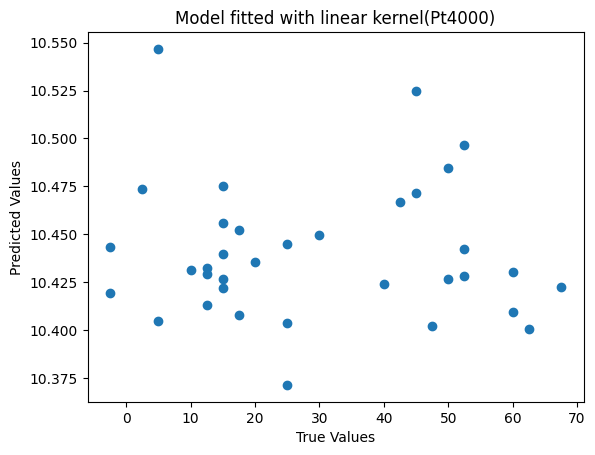

In [95]:
import matplotlib.pyplot as plt

# Create a scatter plot with predicted values on the x-axis and true values on the y-axis
plt.scatter(y1_test, y1_lr_pred)

# Add labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model fitted with linear kernel(Pt4000)')

# Show the plot
plt.show()